In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.stats import chisquare, ks_2samp
import numpy as np

In [2]:
data=pd.read_csv("LendingClub2012to2013.csv",header=1,skiprows=0,skipfooter=2,engine='python')
data.shape

(188181, 115)

In [3]:
#Making the target variable binary
data = data[data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
data['loan_status'] = data['loan_status'].apply(lambda x: 0 if x == "Fully Paid" else 1)
data.shape

(171483, 115)

In [4]:
#checking if there are any duplicates in member_id - no duplicates found
ids = data['member_id']
data[ids.isin(ids[ids.duplicated()])]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit


In [5]:
#dropping variables with more than 50% missing values
pct_null=data.isnull().sum()/len(data)
missing_greater50 = pct_null[pct_null > 0.50].index
data.drop(missing_greater50,axis=1,inplace=True)
data.shape

(171483, 91)

In [6]:
#dropped columns
missing_greater50

Index([u'desc', u'mths_since_last_delinq', u'mths_since_last_record',
       u'next_pymnt_d', u'mths_since_last_major_derog', u'annual_inc_joint',
       u'dti_joint', u'verification_status_joint', u'open_acc_6m',
       u'open_il_6m', u'open_il_12m', u'open_il_24m', u'mths_since_rcnt_il',
       u'total_bal_il', u'il_util', u'open_rv_12m', u'open_rv_24m',
       u'max_bal_bc', u'all_util', u'inq_fi', u'total_cu_tl', u'inq_last_12m',
       u'mths_since_recent_bc_dlq', u'mths_since_recent_revol_delinq'],
      dtype='object')

In [7]:
#dropping columns which are irrelavnt here like dates,text and addresses
data.drop(['member_id','emp_title','purpose','issue_d','url','title','zip_code','addr_state','earliest_cr_line','last_credit_pull_d'],axis=1,inplace=True)
data.shape

(171483, 81)

In [8]:
#dropping columns which are relevant only to a particular set loan_status segment only
data.drop(['collection_recovery_fee','delinq_amnt','last_pymnt_d','last_pymnt_amnt','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp','recoveries','out_prncp','out_prncp_inv'],axis=1,inplace=True)
data.shape

(171483, 69)

In [9]:
#Cleaning few variables - Taking off the % symbol in the interest rate ,the months in tem,the years in emp_length
data['int_rate'] = pd.to_numeric(data['int_rate'].str.strip('%'), errors='coerce')
data['revol_util'] = pd.to_numeric(data['revol_util'].str.strip('%'), errors='coerce')
data['term'] = data['term'].apply(lambda x: x.strip().replace(" ", "_"))
data['emp_length'] = data['emp_length'].apply(lambda x: x.strip('years'))


In [10]:
categorical=data.select_dtypes(include=['object'])
numeric=data.select_dtypes(exclude=['object'])
print(categorical.columns.values)
print(numeric.columns.values)

['term' 'grade' 'sub_grade' 'emp_length' 'home_ownership'
 'verification_status' 'pymnt_plan' 'initial_list_status'
 'application_type']
['id' 'loan_amnt' 'funded_amnt' 'funded_amnt_inv' 'int_rate' 'installment'
 'annual_inc' 'loan_status' 'dti' 'delinq_2yrs' 'fico_range_low'
 'fico_range_high' 'inq_last_6mths' 'open_acc' 'pub_rec' 'revol_bal'
 'revol_util' 'total_acc' 'last_fico_range_high' 'last_fico_range_low'
 'collections_12_mths_ex_med' 'policy_code' 'acc_now_delinq' 'tot_coll_amt'
 'tot_cur_bal' 'total_rev_hi_lim' 'acc_open_past_24mths' 'avg_cur_bal'
 'bc_open_to_buy' 'bc_util' 'chargeoff_within_12_mths' 'mo_sin_old_il_acct'
 'mo_sin_old_rev_tl_op' 'mo_sin_rcnt_rev_tl_op' 'mo_sin_rcnt_tl' 'mort_acc'
 'mths_since_recent_bc' 'mths_since_recent_inq' 'num_accts_ever_120_pd'
 'num_actv_bc_tl' 'num_actv_rev_tl' 'num_bc_sats' 'num_bc_tl' 'num_il_tl'
 'num_op_rev_tl' 'num_rev_accts' 'num_rev_tl_bal_gt_0' 'num_sats'
 'num_tl_120dpd_2m' 'num_tl_30dpd' 'num_tl_90g_dpd_24m'
 'num_tl_op_past

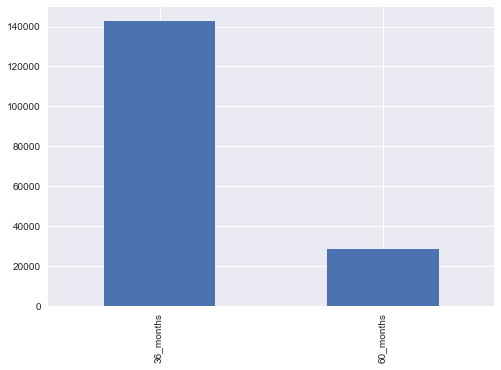

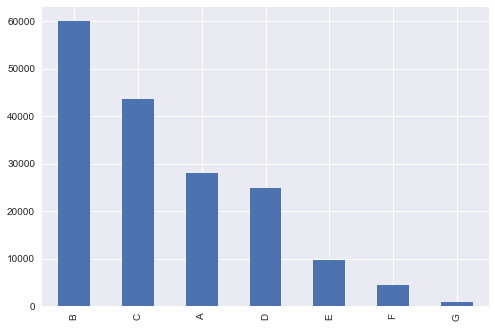

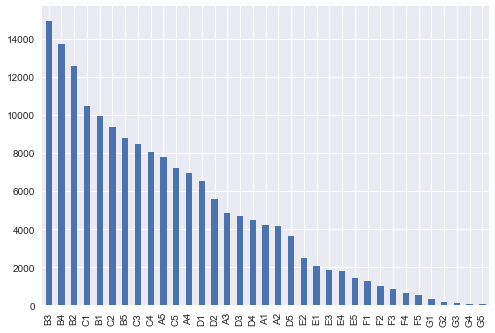

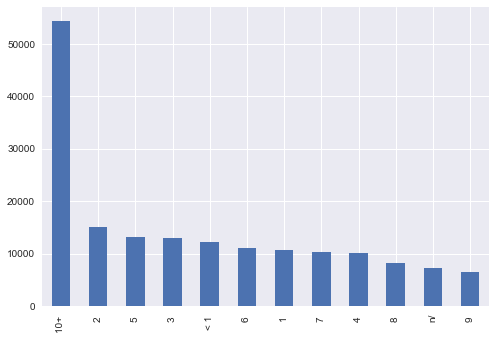

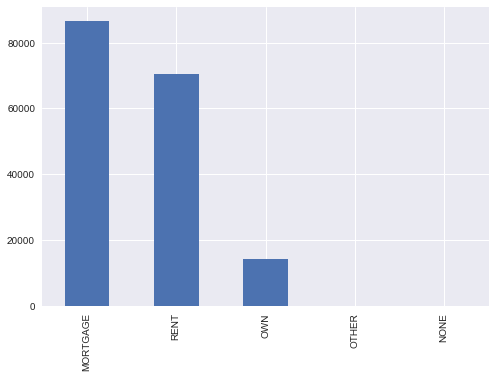

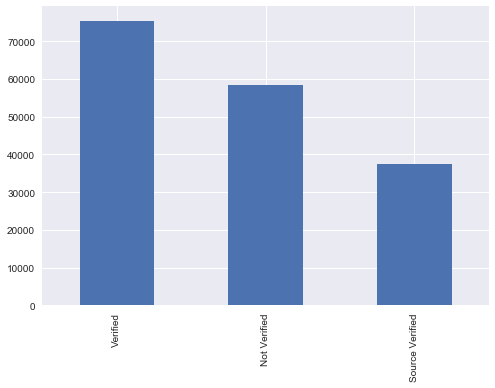

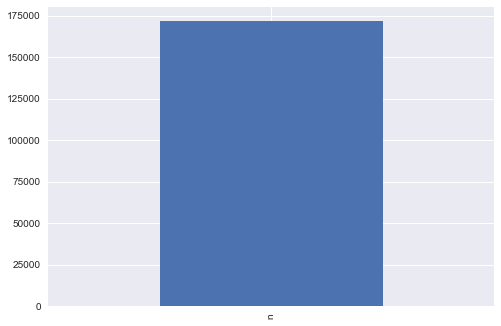

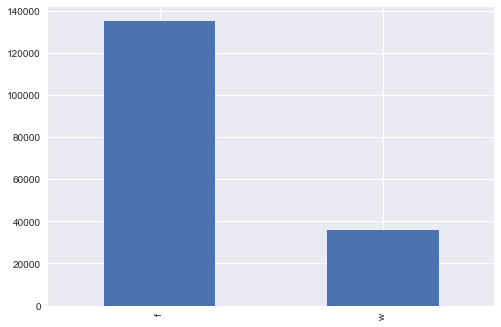

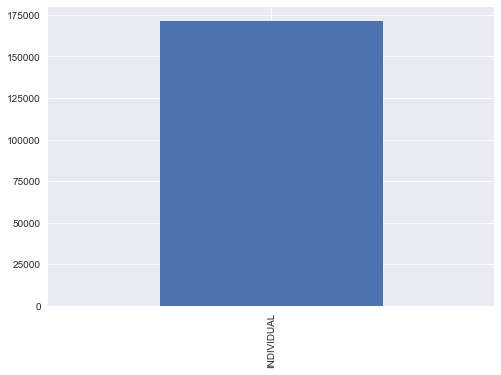

In [11]:
for col in categorical:
    categorical[col].value_counts().plot(kind='bar')
    plt.show()

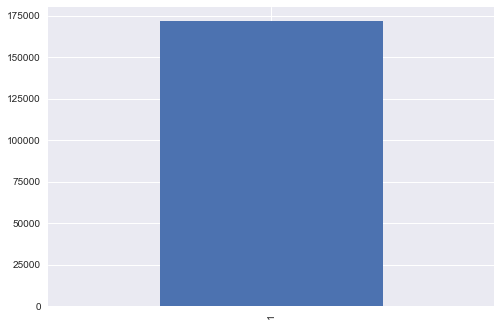

In [12]:
numeric['policy_code'].value_counts().plot(kind='bar')

In [13]:
#These variables have only one category,wont make a differnce even if we have or remove them
data.drop(['application_type','policy_code','pymnt_plan'],axis=1,inplace=True)
data.shape

(171483, 66)

In [14]:
#dropping sub_grade and keeping grade alone
data.drop('sub_grade',axis=1,inplace=True)
data.shape

(171483, 65)

In [15]:
#taking the average of fico_high and fico_low and creating a new variable as fico_avg
data['fico_average']=(data['fico_range_high']+data['fico_range_low'])/2
data.drop(['fico_range_high','fico_range_low'],axis=1,inplace=True)
data.shape

(171483, 64)

In [16]:
#taking the average of last_fico_high and last_fico_low and creating a new variable as fico_avg
data['last_fico_average']=(data['last_fico_range_high']+data['last_fico_range_low'])/2
data.drop(['last_fico_range_high','last_fico_range_low'],axis=1,inplace=True)
data.shape

(171483, 63)

In [17]:
#dropping funded amount as it is correlated to loan amount
data.drop('funded_amnt',axis=1,inplace=True)
data.shape

(171483, 62)

In [18]:
categorical=data.select_dtypes(include=['object'])
numeric=data.select_dtypes(exclude=['object'])
print(categorical.columns.values)
print(numeric.columns.values)

['term' 'grade' 'emp_length' 'home_ownership' 'verification_status'
 'initial_list_status']
['id' 'loan_amnt' 'funded_amnt_inv' 'int_rate' 'installment' 'annual_inc'
 'loan_status' 'dti' 'delinq_2yrs' 'inq_last_6mths' 'open_acc' 'pub_rec'
 'revol_bal' 'revol_util' 'total_acc' 'collections_12_mths_ex_med'
 'acc_now_delinq' 'tot_coll_amt' 'tot_cur_bal' 'total_rev_hi_lim'
 'acc_open_past_24mths' 'avg_cur_bal' 'bc_open_to_buy' 'bc_util'
 'chargeoff_within_12_mths' 'mo_sin_old_il_acct' 'mo_sin_old_rev_tl_op'
 'mo_sin_rcnt_rev_tl_op' 'mo_sin_rcnt_tl' 'mort_acc' 'mths_since_recent_bc'
 'mths_since_recent_inq' 'num_accts_ever_120_pd' 'num_actv_bc_tl'
 'num_actv_rev_tl' 'num_bc_sats' 'num_bc_tl' 'num_il_tl' 'num_op_rev_tl'
 'num_rev_accts' 'num_rev_tl_bal_gt_0' 'num_sats' 'num_tl_120dpd_2m'
 'num_tl_30dpd' 'num_tl_90g_dpd_24m' 'num_tl_op_past_12m' 'pct_tl_nvr_dlq'
 'percent_bc_gt_75' 'pub_rec_bankruptcies' 'tax_liens' 'tot_hi_cred_lim'
 'total_bal_ex_mort' 'total_bc_limit' 'total_il_high_credit

In [19]:
target_name = 'loan_staus'
grouped = data.groupby('loan_status')
variable_names = [name for name in numeric.columns if name in data.columns]

def make_dist_plots(name):
    for g in grouped:
        sns.kdeplot(g[1][name], label = g[0]) 
    plt.legend()
    plt.title(name)
    plt.show()

# Feature selection #1
- We rank continuos features with respenct to the KS-test p-value between samples from catrgory 1 and 0
- KDE distribution estimated are plotted for all continuos features per category to observe the distrubutional difference

56
41
P-value: 0.0


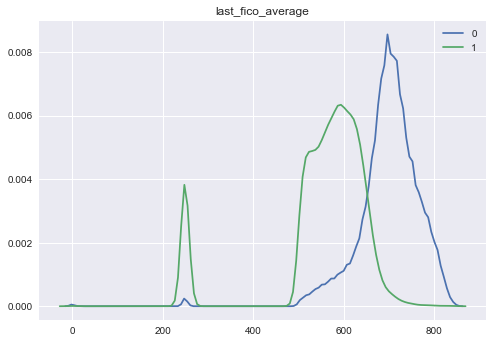

P-value: 0.0


C:\Users\Subiksha\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Subiksha\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Subiksha\Anaconda2\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


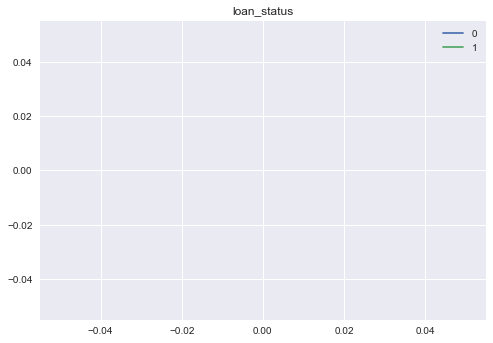

P-value: 0.0


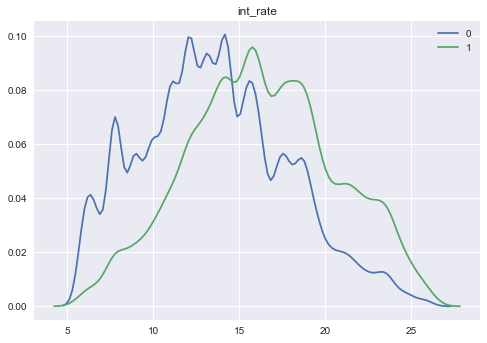

P-value: 0.0


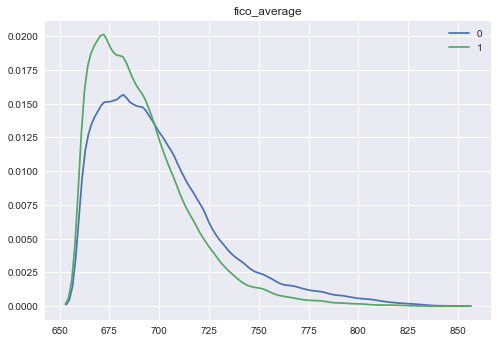

P-value: 7.07690861183e-220


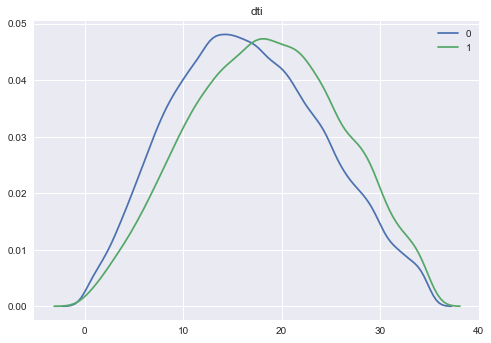

P-value: 6.54322317311e-168


C:\Users\Subiksha\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\Subiksha\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


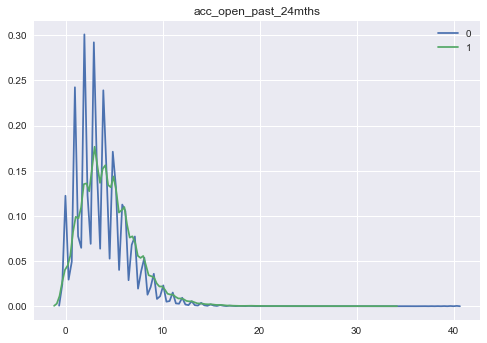

P-value: 1.40210306096e-164


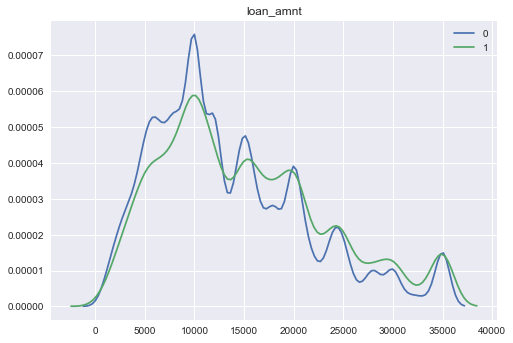

P-value: 3.70605223225e-163


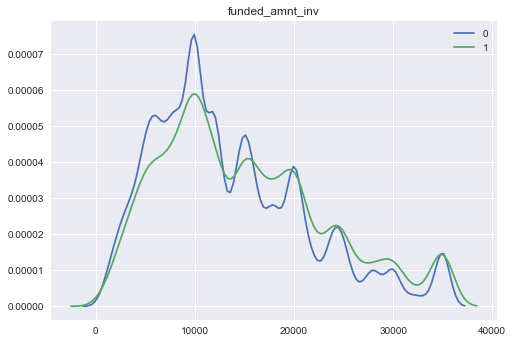

P-value: 5.61362829842e-160


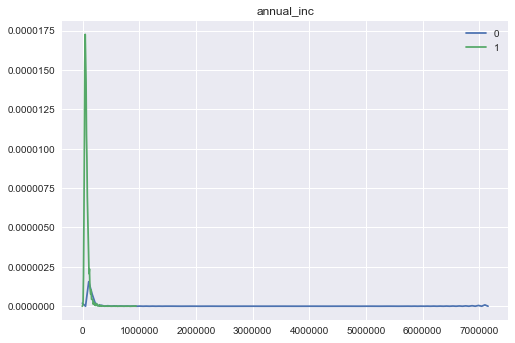

P-value: 1.29395307238e-159


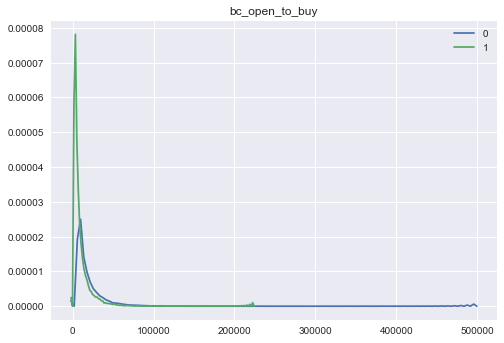

P-value: 8.95208870742e-153


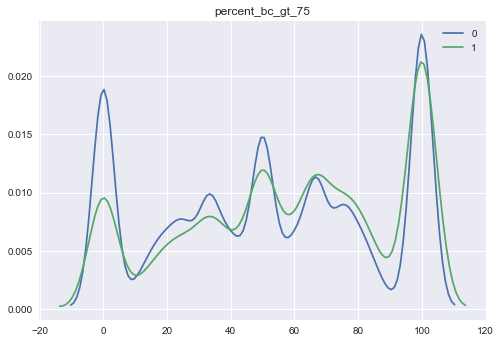

P-value: 7.66861658576e-131


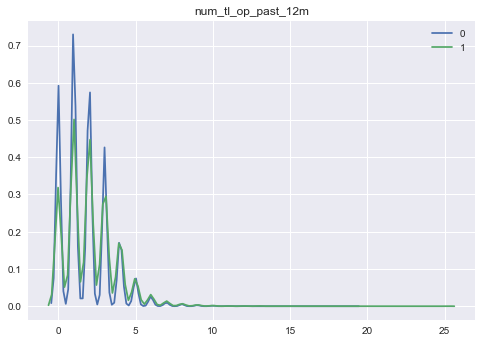

P-value: 1.5681660652e-121


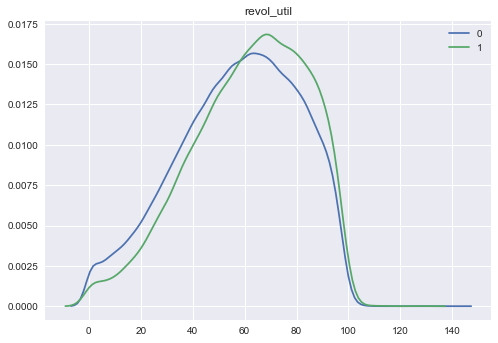

P-value: 2.47995354846e-120


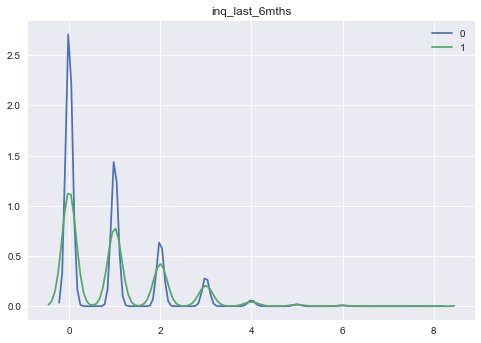

P-value: 7.57519259981e-119


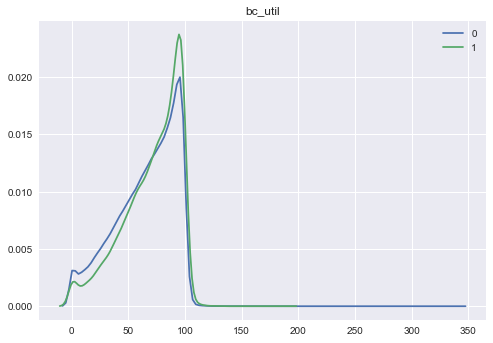

P-value: 7.34899712764e-110


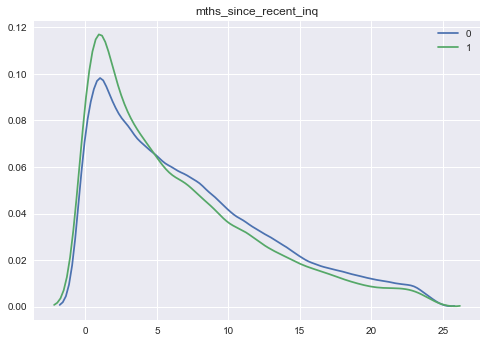

P-value: 1.10788331799e-95


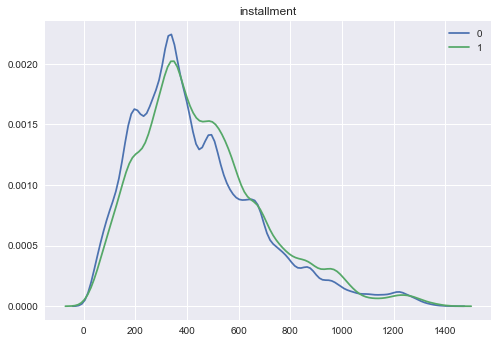

P-value: 1.63579024289e-82


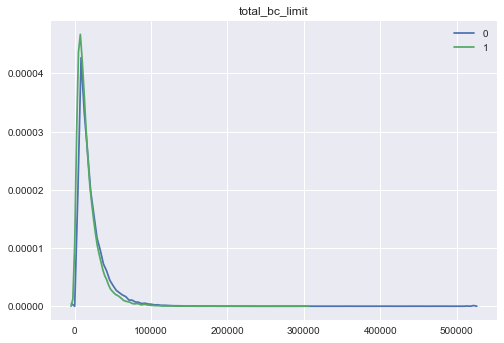

P-value: 4.74007266478e-77


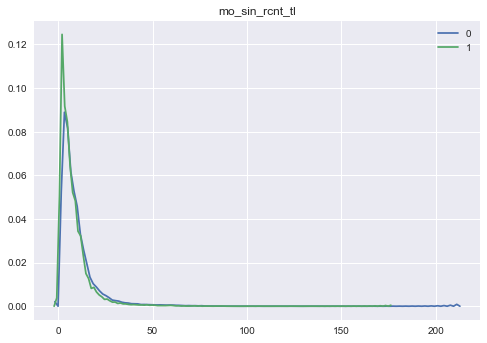

P-value: 2.44442435672e-76


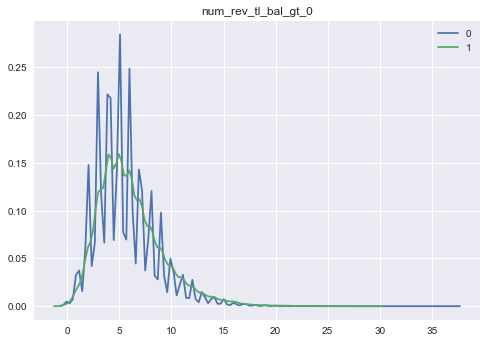

P-value: 1.2450978842e-73


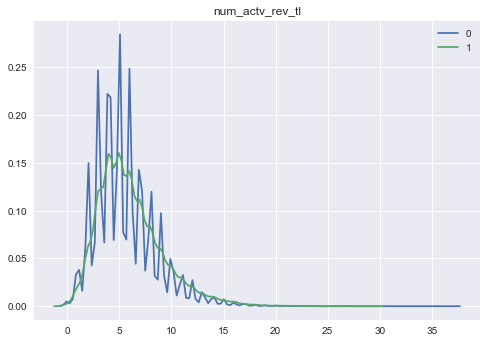

P-value: 1.45312291416e-67


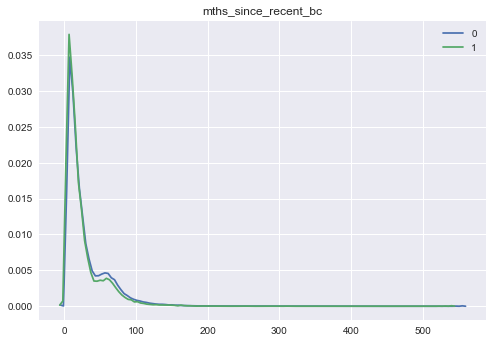

P-value: 7.8457021458e-52


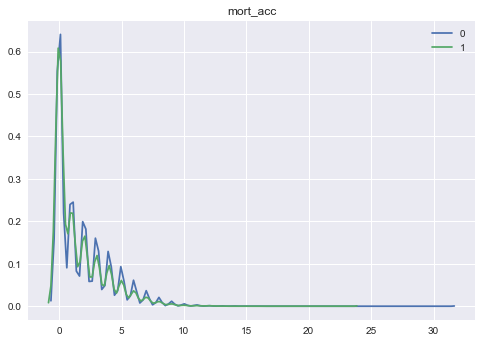

P-value: 9.93960217384e-52


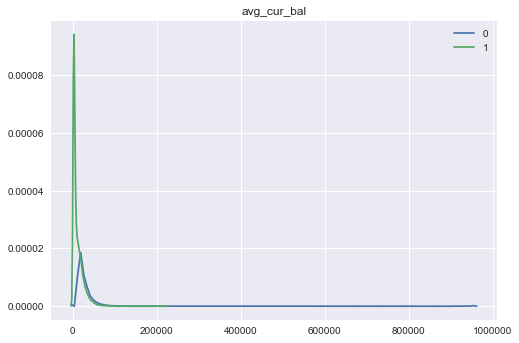

P-value: 4.76083487514e-50


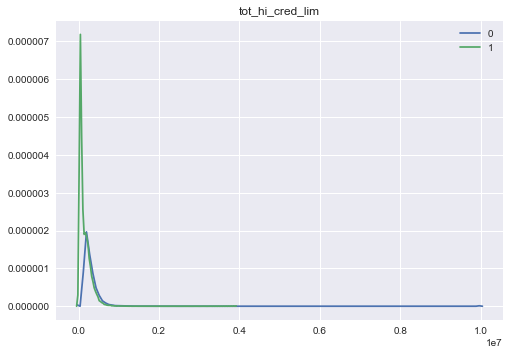

P-value: 1.8513998091e-44


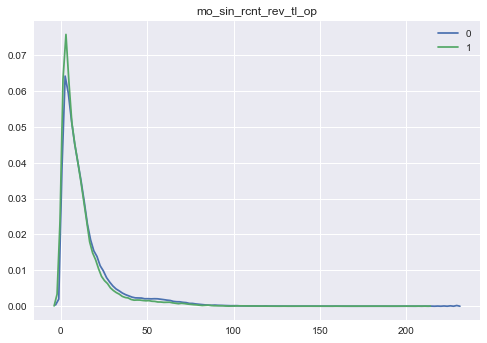

P-value: 1.00792108317e-37


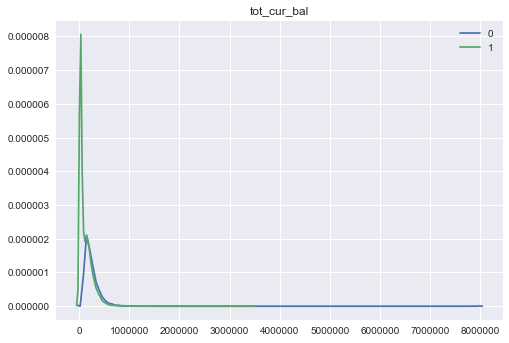

P-value: 4.39506906607e-28


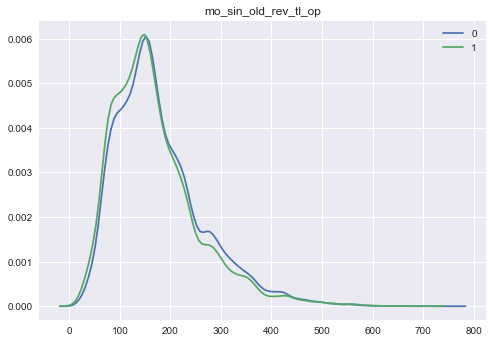

P-value: 1.91781222026e-27


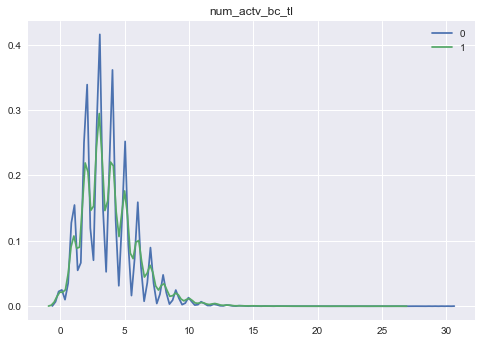

P-value: 2.49276738206e-25


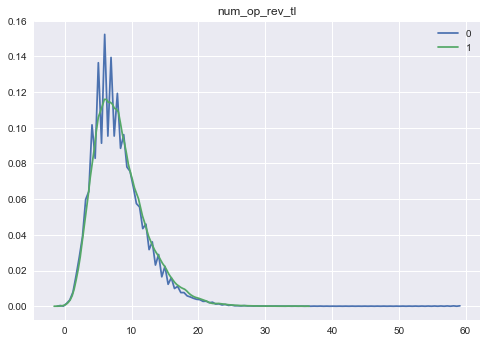

P-value: 1.20300122656e-24


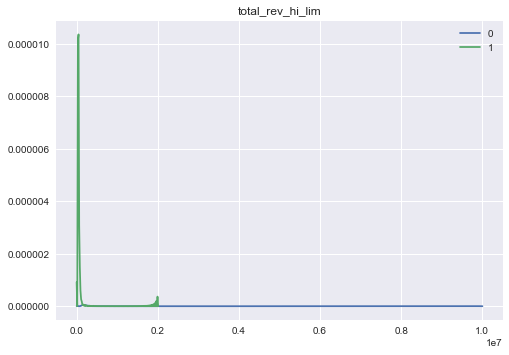

P-value: 1.75584289298e-11


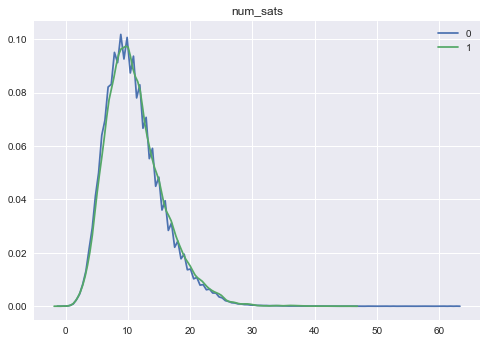

P-value: 1.31713083452e-09


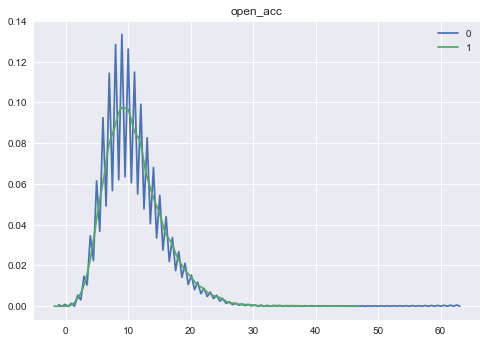

P-value: 5.02915514962e-09


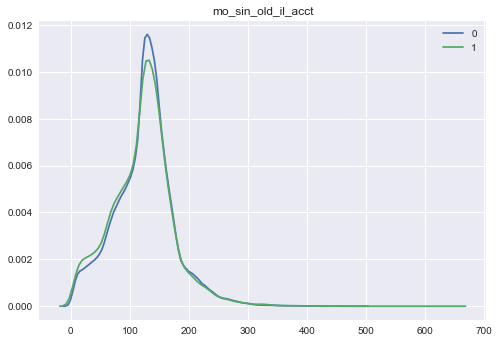

P-value: 2.03697486324e-07


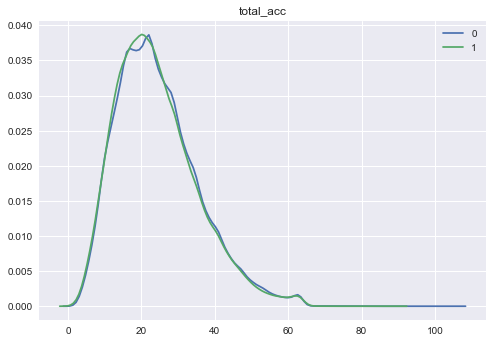

P-value: 4.72269389508e-07


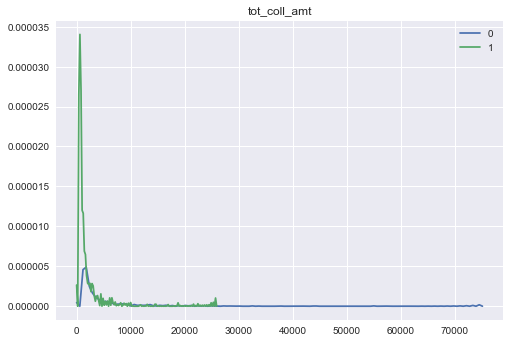

P-value: 9.54595777228e-06


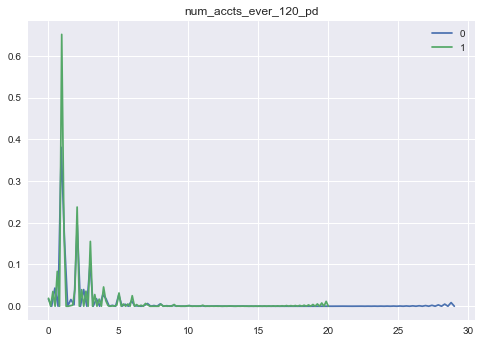

P-value: 1.26292074232e-05


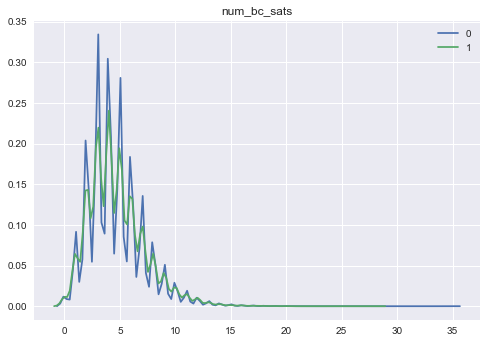

P-value: 4.26215398811e-05


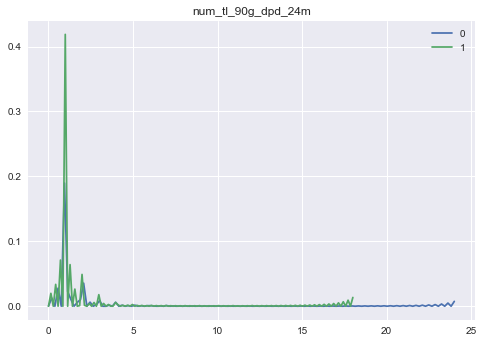

P-value: 4.38766791329e-05


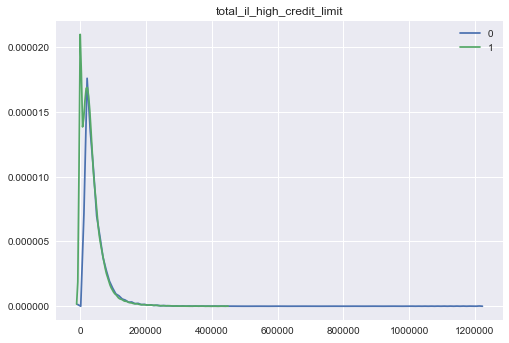

P-value: 5.3483712653e-05


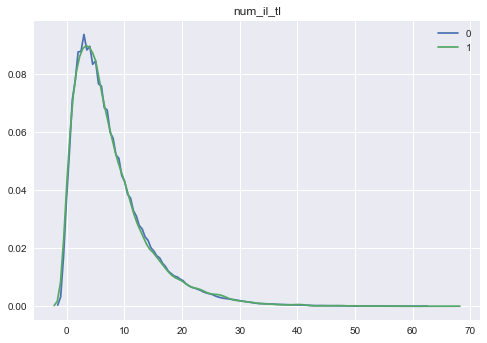

In [20]:
variable_names = numeric.columns.values
print len(variable_names)
grouped = data.groupby('loan_status')
target_name = 'loan_status'

g = [g[1] for g in grouped]
statistics = [ks_2samp(g[0][name], g[1][name]).pvalue for name in variable_names]
    
ordered_variable_names = [(variable_names[ind], statistics[ind]) for ind in np.argsort(statistics) if statistics[ind] < 1e-4]
print len(ordered_variable_names)
for name, value in ordered_variable_names[0:50]:
    print "P-value: " + str(value) 
    make_dist_plots(name)

log_names =["annual_inc", "bc_open_to_buy", "total_rev_hi_lim", "tot_cur_bal", "tot_coll_amt", "num_accts_ever_120_pd", "tot_hi_cred_lim"]
# inq_last_6_mnths : categorical
# Ordinal: mort_acc, num_actv_rev_tl?, num_rec_tl_bal_gt_0, num_ prefix?, open_acc
# reject_names = ["num_il_tl", "num_tl_30dpd", "num_rev_accts", "num_tl_120dpd_2m", "id", "num_bc_tl", "pct_tl_nvr_dlq", "bc_util", "av_cur_bal"]

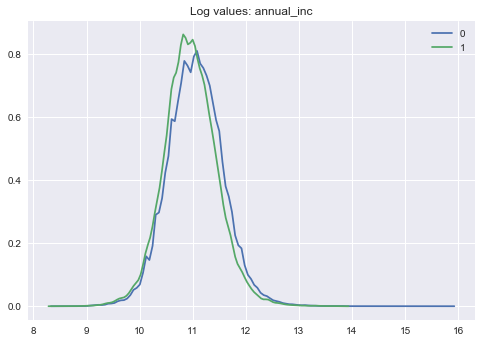

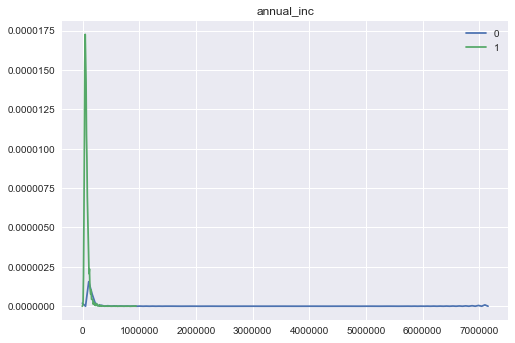

C:\Users\Subiksha\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


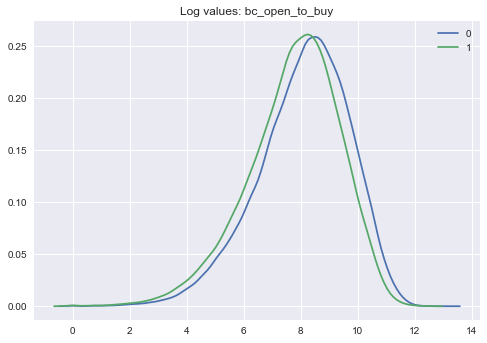

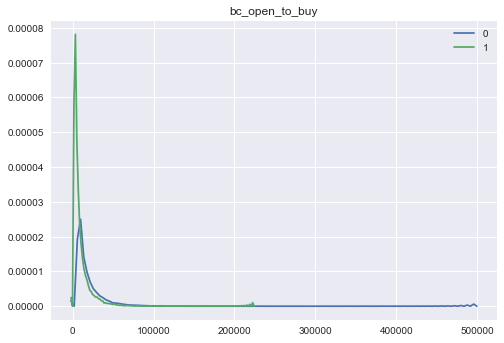

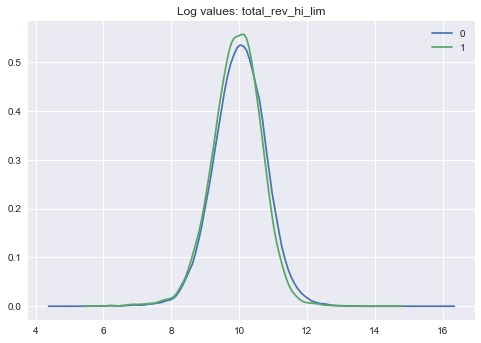

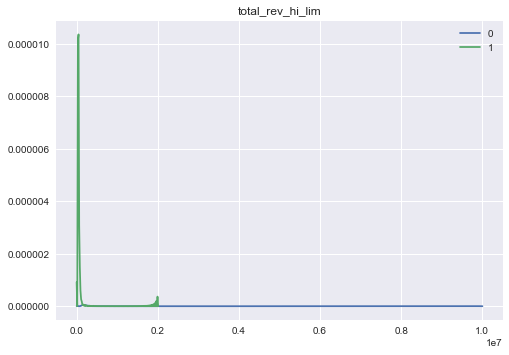

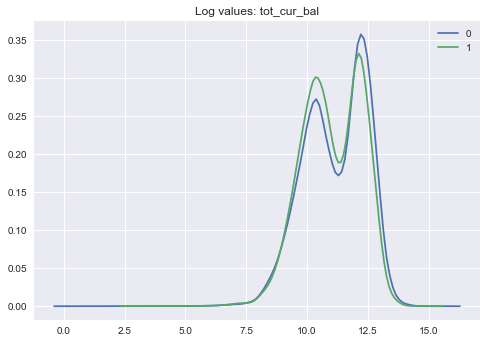

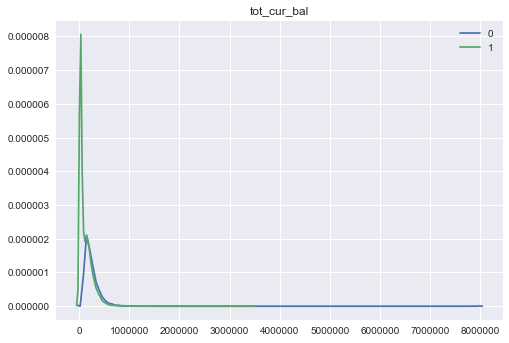

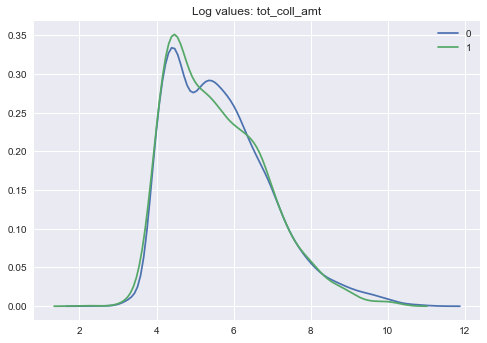

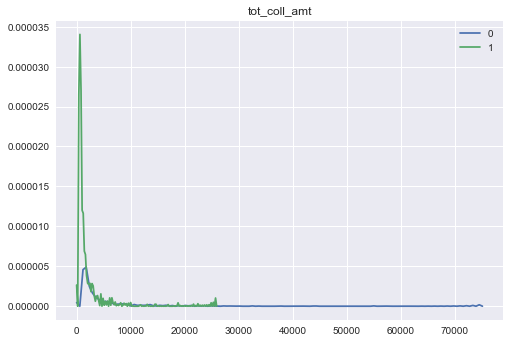

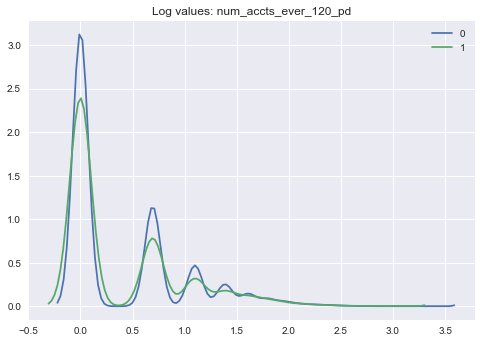

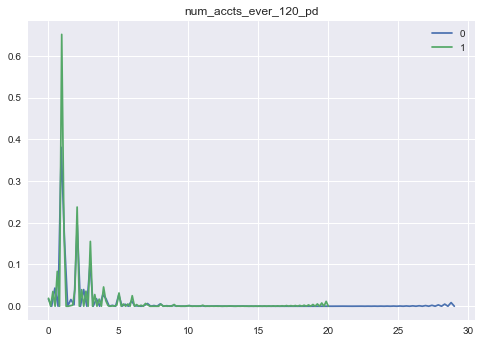

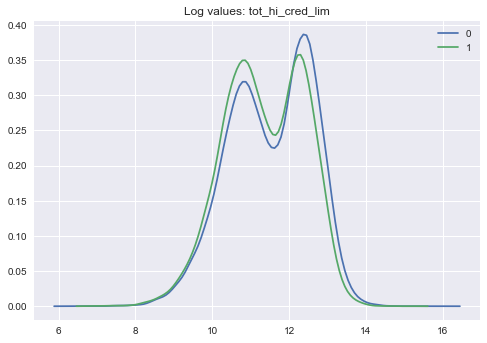

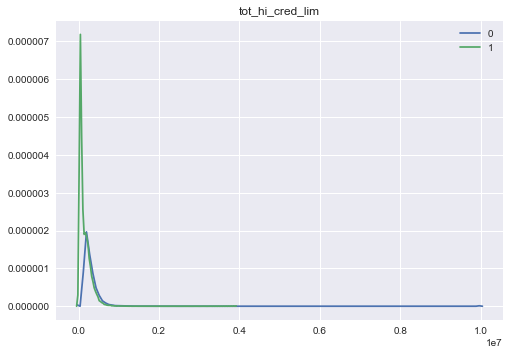

In [21]:
# Displaying the log transformed variables
for name in log_names:
    for g in grouped:
        sns.kdeplot(np.log(g[1][name]), label = g[0])
    plt.title("Log values: " + name)
    plt.show()
    for g in grouped:
        sns.kdeplot(g[1][name], label = g[0])
    plt.title(name)
    plt.show() 

# Feature Selection #2
* Categorical features are compared using a chi-sq test for independece
* We reject the features that do not pass the test

In [22]:
from collections import Counter
from scipy.stats import chi2_contingency

variable_names = categorical.columns

def get_chi2_pvalue(feature_name):
    list_counts = [map(lambda x: x[1], Counter(g[1]['loan_status']).items()) for g in data.groupby(feature_name)]
    return chi2_contingency(np.array(list_counts))[1]

print "The chisq p values are:" + str(map(get_chi2_pvalue, variable_names))

#Check the missing count of each column.
is_null_count = data.isnull().sum()
print [is_null_count[v] for v in variable_names]

The chisq p values are:[0.0, 0.0, 1.867977371584669e-19, 1.2595639629629601e-58, 1.2865614241958705e-225, 1.8410942768170244e-12]
[0, 0, 0, 0, 0, 0]


The categorical features all significantly affect the loan status. Thus we cannot eliminate any of them from our model. These features are also not missing frequently thus, we do not need to perform any imputation.

In [23]:
names, stats = zip(*ordered_variable_names)
# Creating the preprocessed dataset
for name in numeric.columns:
    if name not in names and name != "id":
        data.drop(name, axis = 1, inplace = True)

In [24]:
#Replacing with log for the skewed variables
for name in log_names:
    data[name] = (data[name] > 0)*np.log(data[name])
data.shape

C:\Users\Subiksha\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


(171483, 48)

In [25]:
#creating dummy variables
term_dummies = pd.get_dummies(data['term'], prefix="term_")
grade_dummies = pd.get_dummies(data['grade'], prefix="grade")
emp_length_dummies = pd.get_dummies(data['emp_length'])
home_ownership_dummies = pd.get_dummies(data['home_ownership'])
verification_status_dummies = pd.get_dummies(data['verification_status'])
initial_list_status_dummies = pd.get_dummies(data['initial_list_status'])

#combine the dummies back in
data = pd.concat([data, term_dummies, grade_dummies,emp_length_dummies,home_ownership_dummies,verification_status_dummies,initial_list_status_dummies], axis=1)
#dropping the original columns
data.drop(['term','grade','emp_length','home_ownership','verification_status','initial_list_status'], axis = 1, inplace = True)
#rename the term columns
data.rename(columns={'term__ 36 months': 'term_36_months', 'term__ 60 months': 'term_60_months'}, inplace=True)

In [26]:
from sklearn.model_selection import train_test_split

Y = data['loan_status']
X = data.drop(['loan_status','id'], axis=1)

# Imputing the data by replacing all NaN with -1
#X[X.isnull()] = -1
# Designing a new feature based on missing variables
#l, v = np.linalg.eig(X.isnull().cov().as_matrix())
#mis_variable = 1*(np.dot(X.isnull(), v)[:,0]<-2.5)
#X['miss_variable'] = mis_variable
#for g in data.groupby('loan_status'):
#    print 'The mean probability for category - ' + str(g[0]) + ':' + str(np.mean(g[1]['miss_variable']))


#Imputing missing values
numeric=X.select_dtypes(exclude=['object'])
for name in numeric:
    if pd.isnull(X[name]).sum() > 0:
        X["%s_mi" % (name)] = pd.isnull(X[name])
        median = X[name].median()
        X[name] = X[name].apply(lambda x: median if pd.isnull(x) else x)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

# Training a decision tree on the reduced dataset

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score



## Doing 10 fold cross validation to determine the best tree depth

In [28]:
from sklearn.model_selection import cross_val_score

performance = []
for max_depth in [2,3,5,7,10]:
    dTree = DecisionTreeClassifier(criterion='entropy', class_weight = "balanced", max_depth=max_depth)
    performance.append((max_depth, np.mean(cross_val_score(dTree, X_train, Y_train, cv = 10, scoring = "f1_micro"))))

In [29]:
print performance
print "The best tree size is: " + str(sorted(performance, key = lambda x: x[1])[-1][0])

[(2, 0.8246662834434918), (3, 0.8246662834434918), (5, 0.85702714996254969), (7, 0.85314737028413323), (10, 0.84951623739716875)]
The best tree size is: 5


In [30]:
from sklearn.model_selection import cross_val_score, KFold

dTree = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', max_depth = 5)
kf = KFold(n_splits=10, shuffle=True, random_state=0)
dTree.fit(X_train, Y_train)

print "Test Results:"
y_prediction = dTree.predict(X_test)
print classification_report(Y_test, y_prediction)

Test Results:
             precision    recall  f1-score   support

          0       0.98      0.85      0.91     36080
          1       0.53      0.90      0.67      6791

avg / total       0.91      0.86      0.87     42871



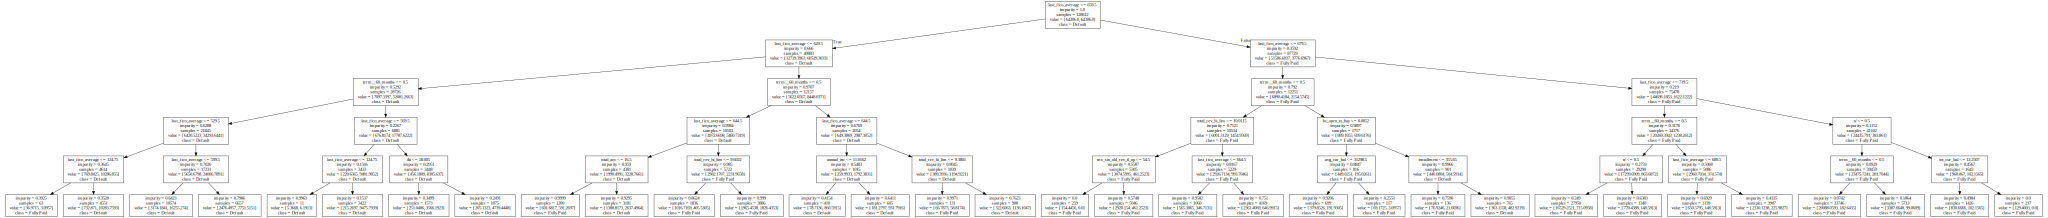

In [31]:
from StringIO import StringIO
import sklearn
import graphviz
import sklearn.tree
import numpy as np

ss = StringIO()

sklearn.tree.export_graphviz(dTree.tree_,label="all", out_file=ss, feature_names = X.columns,class_names=['Fully Paid','Default'])
graphviz.Source(ss.getvalue())

# Logistic regression classifier
* Data is normalized to mean 0, std 1
* We use l1 regularization to select features
* Cross validation is used to select the best setting for the regularization constant

In [32]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normal = scaler.fit_transform(X_train)
X_test_normal = scaler.transform(X_test)

model = LogisticRegressionCV(Cs = 10, cv = 10, class_weight = "balanced")
model.fit(X_train_normal, Y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [33]:
y_prediction = model.predict(X_test_normal)
print classification_report(y_prediction, Y_test)

             precision    recall  f1-score   support

          0       0.87      0.97      0.92     32320
          1       0.87      0.56      0.68     10551

avg / total       0.87      0.87      0.86     42871



## Finding the best variables for prediction

In [34]:
print 100*np.abs(model.coef_)/np.sum(np.abs(model.coef_))
print X_train.columns[np.argsort(-np.abs(model.coef_))[0][0:7]]

[[  3.29721431e+00   3.89297134e+00   4.13897178e-01   4.40508334e+00
    3.61762458e+00   1.53919165e+00   6.00147955e-01   1.95650737e-01
    1.73749201e-01   2.41446402e+00   3.30738777e-01   2.67537022e+00
    9.99683970e-01   3.32039918e-01   1.23819776e+00   2.45175169e-01
    2.48603206e-02   9.17557547e-03   9.35589952e-01   3.61929825e-01
    3.21985948e-01   3.38977885e-01   3.43271862e-02   2.55339571e-01
    3.20940232e-01   2.35480152e-01   2.18911598e+00   2.86373521e-02
    8.67862924e-01   5.96692808e-01   1.26086656e+00   8.35793836e-01
    1.42950275e-01   4.84891760e-01   2.34627389e-01   2.10525469e+00
    4.25919431e-01   7.92609271e-01   1.35308613e+00   3.67473158e+01
    2.67303518e+00   2.67303518e+00   2.98463160e-01   1.09737951e-01
    2.37045996e-01   2.48114237e-01   3.58893500e-02   9.87116401e-02
    5.50774896e-02   9.37016685e-02   8.78918557e-02   7.59342502e-02
    1.37498235e-01   3.03570460e-01   6.46924461e-02   2.07676219e-01
    8.61479005e-02  

# Naive Bayes classifier

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
clf = GaussianNB()
clf.fit(X_train, Y_train)

predicted_naive_bayes=clf.predict(X_test)
print (metrics.confusion_matrix(Y_test, predicted_naive_bayes))
print (metrics.classification_report(Y_test, predicted_naive_bayes))

[[31879  4201]
 [ 2714  4077]]
             precision    recall  f1-score   support

          0       0.92      0.88      0.90     36080
          1       0.49      0.60      0.54      6791

avg / total       0.85      0.84      0.84     42871



# K-Nearest Neighbour classifier
Performing 10 fold cross validation to find the best k value

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

performance = []
for k_value in range(1,10):
    knn_classification = neighbors.KNeighborsClassifier(n_neighbors=k_value, weights='uniform')
    performance.append((k_value, np.mean(cross_val_score(knn_classification, X_train, Y_train, cv = 10, scoring = "f1_micro"))))

In [37]:
print performance
print "The best k-value is: " + str(sorted(performance, key = lambda x: x[1])[-1][0])

[(1, 0.75224713720421876), (2, 0.82454202141243516), (3, 0.80152708098409353), (4, 0.83031131043233375), (5, 0.8200634435925096), (6, 0.83343699162811402), (7, 0.82789318568079451), (8, 0.83583956246738078), (9, 0.83272165792833996)]
The best k-value is: 8


In [38]:
from sklearn import metrics
from sklearn import neighbors

knearest_clf = neighbors.KNeighborsClassifier(n_neighbors=8, weights='uniform') 
knearest_clf.fit(X_train, Y_train)
predicted_knn_classifier=knearest_clf.predict(X_test)

#predicted_knn_classifier = 1*(predicted_probabilities > np.mean(Y_train))
print metrics.confusion_matrix(Y_test, predicted_knn_classifier)
print metrics.classification_report(Y_test,predicted_knn_classifier)

[[35775   305]
 [ 6610   181]]
             precision    recall  f1-score   support

          0       0.84      0.99      0.91     36080
          1       0.37      0.03      0.05      6791

avg / total       0.77      0.84      0.78     42871

